# Socioeconomic data and TOC entitlements
* Entitlements assigned to census tracts
* Which census tracts (what income levels or median household income) have seen TOC entitlements?
* See if tract is composed of mostly TOC-eligible parcels
* Then look at Census characteristics of mostly TOC-eligible tracts vs not

In [1]:
import boto3
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pcts_census_utils
import utils

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## Identify this dichotomy of tracts that are mostly TOC-eligible vs not

In [3]:
def toc_tracts_clean_and_aggregate():
    # Import data
    crosswalk_parcels_tracts = pd.read_parquet(f's3://{bucket_name}/data/crosswalk_parcels_tracts.parquet')

    s3.download_file(bucket_name, f'gis/intermediate/TOC_Parcels.parquet', '../gis/TOC_Parcels.parquet')
    toc_parcels = gpd.read_parquet('../gis/TOC_Parcels.parquet')
    os.remove('../gis/TOC_Parcels.parquet')

    df = pd.merge(crosswalk_parcels_tracts, 
         toc_parcels[toc_parcels.TOC_Tier > 0].drop(columns = 'TOC_Tier'), 
         on = 'AIN', how = 'left', validate = '1:1')
    
    # Get rid of duplicate AIN's
    df = df[df.num_AIN == 1]
    
    # Tag if the parcel counts as in TOC tier or not
    def in_tier(row):
        if row.TOC_Tier != 0:
            return 1
        elif row.TOC_Tier == 0:
            return 0

    df = df.assign(
        in_tier = df.apply(in_tier, axis=1)
    )
    
    # Aggregate by in_tier 
    df = (df.groupby(["GEOID", "pop", "parcel_tot", "in_tier"])
          .agg({"num_AIN": "sum",
               "parcelsqft":"sum"})
          .reset_index()
         )
    
    # If GEOID has 2 observations, one in_tier==1 and other in_tier==0, let's keep the in_tier==1
    df["obs"] = df.groupby("GEOID").cumcount() + 1
    df["max_obs"] = df.groupby("GEOID")["obs"].transform("max")
    
    df = (df[(df.max_obs == 1) | 
             ((df.in_tier == 1) & (df.max_obs == 2))]
          .drop(columns = ["obs", "max_obs"])
         )
    
    
    # Also, count the total of AIN within each tract
    total_AIN = (crosswalk_parcels_tracts[crosswalk_parcels_tracts.num_AIN == 1]
                    .groupby(['GEOID'])
                    .agg({'num_AIN':'sum'})
                    .rename(columns = {'num_AIN':'total_AIN'})
                    .reset_index()
                   )
    
    # Merge together 
    df2 = pd.merge(df, total_AIN, on = 'GEOID', how = 'left', validate = 'm:1')
    
    # Calculate the % of AIN that falls within TOC tiers and % of area within TOC tiers
    df2 = (df2.assign(
            pct_AIN = df2.num_AIN / df2.total_AIN,
            pct_area = df2.parcelsqft / df2.parcel_tot,
        ).sort_values("GEOID")
           .reset_index(drop=True)
    )
    
    return df2

In [4]:
df = toc_tracts_clean_and_aggregate()

## Grab Census data

In [5]:
# Commute mode
commute_modes = ["workers_transit", "workers_walk", "workers_bike"]

commute = pcts_census_utils.transform_census_percent("commute", 2018, "workers", 
                                   commute_modes, "non_car", 
                                   "non_car", "workers_total")

commute.head(2)

,GEOID,non_car,workers_total,pct_non_car
0,06037101110,46,1927,0.023871
1,06037101122,11,1907,0.005768


In [6]:
# Renter occupied
tenure_group = ["pop_renter"]

tenure = pcts_census_utils.transform_census_percent("tenure", 2018, "pop", 
                                  tenure_group, "pop_renter", 
                                  "pop_renter", "pop_total")

tenure.head(2)

,GEOID,pop_renter,pop_total,pct_pop_renter
0,06037101110,2199,4219,0.521214
1,06037101122,577,3234,0.178417


In [7]:
# Zero vehicle 
vehicle_group = ["workers_veh0"]

vehicle = pcts_census_utils.transform_census_percent("vehicles", 2018, "workers", 
                                   vehicle_group, "zero_veh_workers",
                                   "zero_veh_workers", "workers_total")

vehicle.head(2)

,GEOID,workers_total,zero_veh_workers,pct_zero_veh_workers
0,06037101110,1927,0,0.000000
1,06037101122,1907,8,0.004195


In [8]:
# Race 
race_group = ["pop_black", "pop_asian", "pop_amerind", "pop_pacis", "pop_race2", "pop_other"]

race = pcts_census_utils.transform_census_percent("race", 2018, "pop", 
                                   race_group, "non_white",
                                   "non_white", "pop_total")

race.head(2)

,GEOID,non_white,pop_total,pct_non_white
0,06037101110,1000,4314,0.231803
1,06037101122,402,3239,0.124112


## Merge in Census data

In [9]:
# Grab the geometry for tracts
census_tracts = catalog.census_tracts.read()
census_tracts = (census_tracts[["GEOID10", "geometry"]]
                 .rename(columns = {"GEOID10": "GEOID"})
                 .to_crs("EPSG:4326")
                )

In [10]:
# Merge the census pieces together
c1 = pd.merge(commute, vehicle, on = ["GEOID", "workers_total"], how = "left", validate = "1:1")
c2 = pd.merge(tenure, race, on = ["GEOID", "pop_total"], how = "left", validate = "1:1")
c3 = pd.merge(c1, c2, on = "GEOID", how = "left", validate = "1:1")

# Skip income for now, need to use incomerange table
"""
Denominators
zero_veh_workers / workers_total
non_car / workers_total
pop_renter / pop_total
non_white / pop_total
"""

drop_me = ["pct_non_car", "pct_zero_veh_workers", "pct_pop_renter", "pct_non_white"]
c3 = c3.drop(columns = drop_me)

# Merge our TOC info with census info
c4 = pd.merge(df, c3, on = "GEOID", how = "left", validate = "1:1")

# Merge in geometry
c5 = pd.merge(census_tracts, c4, on = "GEOID", how = "left", validate = "1:1")

## Summary stats
Instead of unweighted averages, we should definitely weight by population. 
Aggregate counts for # non car, # zero veh workers, etc into the 2 groups.
Then calculate % non car, % zero veh workers, etc.

In [11]:
# We will count tract as being a TOC tract if over 50% of its area or 
# over 50% of its parcels are within a TOC Tier.
def set_groups(df):
    cutoff_AIN = 0.5
    cutoff_area = 0.5
    
    def set_cutoffs(row):
        toc_AIN = 0
        toc_area = 0
        
        if (row.in_tier == 1) & (row.pct_AIN >= cutoff_AIN):
            toc_AIN = 1
        if (row.in_tier == 1) & (row.pct_area >= cutoff_area):
            toc_area = 1
        
        return pd.Series([toc_AIN, toc_area], index=['toc_AIN', 'toc_area'])
    
    with_cutoffs = df.apply(set_cutoffs, axis=1)
    
    df = pd.concat([df, with_cutoffs], axis=1)
    
    return df

In [12]:
final = set_groups(c5)
final.head(2)

,GEOID,geometry,pop,parcel_tot,in_tier,num_AIN,parcelsqft,total_AIN,pct_AIN,pct_area,non_car,workers_total,zero_veh_workers,pop_renter,pop_total,non_white,toc_AIN,toc_area
0,06037297602,"MULTIPOLYGON (((-118.28798 33.72258, -118.2879...",4048,3.953546e+06,1.0,101.0,5.522768e+05,821.0,0.123021,0.139692,101,1840,77,2065,3730,<NA>,0,0
1,06037297601,"MULTIPOLYGON (((-118.27738 33.70783, -118.2773...",2706,1.770137e+06,0.0,256.0,1.706503e+06,256.0,1.000000,0.964051,42,1147,26,2244,2706,<NA>,0,0


In [13]:
# Income (use ranges to calculate median)
# These have to be calculated after tracts are ID as TOC or not
income_ranges = pcts_census_utils.income_ranges

# The new_var columns to keep all have prefix "total_". 
# Can switch out if we're interested in other races' income ranges
keep = []
for x in income_ranges:
    keep.append("total_" + x)

def process_income_before_iqr():
    df = pcts_census_utils.grab_census_table("incomerange", 2018, "total")
    df = df.pivot(index="GEOID", columns = "new_var", values = "num")
    df.columns.name = ""
    df = df.reset_index()
    
    return df

income = process_income_before_iqr()
income.head(2)

,GEOID,total_gt200,total_lt10,total_r100to124,total_r10to14,total_r125to149,total_r150to199,total_r15to19,total_r20to24,total_r25to29,total_r30to34,total_r35to39,total_r40to44,total_r45to49,total_r50to59,total_r60to74,total_r75to99,total_total
0,06037101110,44.0,110.0,91.0,97.0,93.0,109.0,70.0,76.0,123.0,96.0,54.0,78.0,88.0,64.0,126.0,277.0,1596.0
1,06037101122,192.0,52.0,114.0,18.0,105.0,133.0,0.0,15.0,39.0,38.0,7.0,40.0,23.0,62.0,186.0,232.0,1256.0


In [14]:
print(f"# tracts where groups differ based on cut-offs: {len(final[final.toc_area != final.toc_AIN])}")
print(final.toc_area.value_counts())
print(final.toc_AIN.value_counts())

# tracts where groups differ based on cut-offs: 30
0    604
1    545
Name: toc_area, dtype: int64
0    600
1    549
Name: toc_AIN, dtype: int64


In [15]:
# Calculate IQR for income
def aggregate_by_toc(df, category_col, income_df):
    df = df[["GEOID", category_col]]

    df2 = pd.merge(df, income_df, on = "GEOID", how = "left", validate = "1:1")

    # Aggregate by toc_area or toc_AIN
    df2 = df2.pivot_table(index = category_col, aggfunc = "sum").reset_index()
    
    # Calculate IQR
    iqr = (df2.apply(
            lambda r: pd.Series(pcts_census_utils.income_percentiles(r, [25,50,75]), dtype="float64"),
            axis=1,
        ).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})
    )
    
    # Change unit income IQR from thousands of dollars to dollars
    DOLLAR_UNIT = 1_000
    
    iqr = (iqr.assign(
            Q1 = iqr.Q1 * DOLLAR_UNIT,
            Q2 = iqr.Q2 * DOLLAR_UNIT, 
            Q3 = iqr.Q3 * DOLLAR_UNIT,
        ).rename(columns = {"Q1": "income_Q1", "Q2": "income_Q2", "Q3": "income_Q3"})
    )

    # Merge IQR in
    df3 = pd.merge(df2[[category_col]], iqr, left_index = True, right_index = True, 
                   how = "left", validate = "1:1")
    
    return df3

def summary_stats(df, category_col, income_df):
    # Number of tracts by cut-offs
    num_tracts = (df.groupby(category_col).agg({
            "GEOID": "count"
        }).reset_index()
            .rename(columns = {"GEOID": "num_tracts"})
    )
    
    # Calculate totals
    totals = df.groupby(category_col).agg({
            "zero_veh_workers": "sum",
            "non_car": "sum",
            "workers_total": "sum",
            "pop_renter": "sum",
            "non_white": "sum",
            "pop_total": "sum",
    }).reset_index()
    
    # Calculate percents
    percents = totals.assign(
        pct_zero_veh = totals.zero_veh_workers / totals.workers_total,
        pct_non_car = totals.non_car / totals.workers_total,
        pct_renter = totals.pop_renter / totals.pop_total,
        pct_non_white = totals.non_white / totals.pop_total,
    )
    
    # Calculate income IQR
    income_iqr = aggregate_by_toc(df, category_col, income_df)
    
    # Create final table
    summary = pd.merge(percents, num_tracts, on = category_col, validate = "1:1")
    summary = pd.merge(summary, income_iqr, on = category_col, validate = "1:1")
    
    return summary

In [16]:
by_AIN = summary_stats(final, "toc_AIN", income)
by_AIN

,toc_AIN,zero_veh_workers,non_car,workers_total,pop_renter,non_white,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_non_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,25474,68832,908927,835758,242878,1840124,0.028026,0.075729,0.454186,0.131990,600,35513.929030,74390.156778,137414.803186
1,1,95431,198640,1046500,1501681,410265,2082857,0.091191,0.189814,0.720972,0.196972,549,22581.190387,48225.917068,93110.836769


In [17]:
by_area = summary_stats(final, "toc_area", income)
by_area

,toc_area,zero_veh_workers,non_car,workers_total,pop_renter,non_white,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_non_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,25446,70538,917375,836060,246378,1853999,0.027738,0.076891,0.450950,0.132890,604,35751.293048,74838.461538,138283.334452
1,1,95459,196934,1038052,1501379,406765,2068982,0.091960,0.189715,0.725661,0.196602,545,22358.011215,47672.337644,92041.996104


In [18]:
writer = pd.ExcelWriter("../outputs/07-toc-census-stats.xlsx", engine="xlsxwriter")

by_AIN.to_excel(writer, sheet_name = "by_pct_AIN")
by_area.to_excel(writer, sheet_name = "by_pct_area")

writer.save()

## Make map of tracts by_AIN

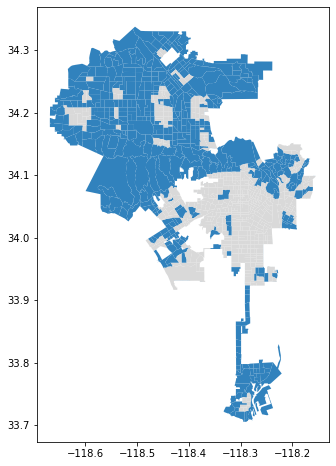

In [19]:
fig, ax = plt.subplots(figsize=(8,8))

final.plot(column="toc_AIN", ax=ax, cmap = "tab20c", legend=False)